# Code

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import time

In [4]:
# import data
all_data = pd.read_csv('icml_face_data.csv')

all_data = all_data[0:700] # just for dev... remove for actual training
accuracy = {}


In [5]:
all_data.rename({' Usage': 'Usage', ' pixels': 'pixels'}, axis=1, inplace=True)

In [6]:
def pixels_to_arr(pixels):
    array = np.array(pixels.split(),'float64')
    return array

all_data['pixels_arr'] = all_data['pixels'].apply(pixels_to_arr)

In [7]:
def image_reshape(data):
    image = np.reshape(data['pixels_arr'].to_list(),(data.shape[0],48,48,1))
    return image

X = image_reshape(all_data)
y = all_data['emotion']

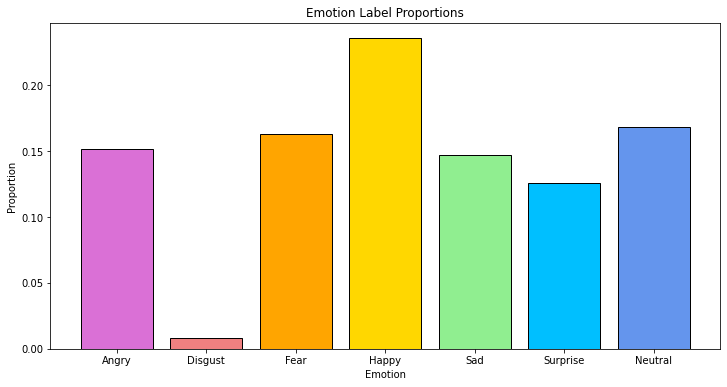

In [8]:
emotion_prop = (all_data.emotion.value_counts() / len(all_data)).to_frame().sort_index(ascending=True)

emotions = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
palette = ['orchid', 'lightcoral', 'orange', 'gold', 'lightgreen', 'deepskyblue', 'cornflowerblue']

plt.figure(figsize=[12,6])

plt.bar(x=emotions, height=emotion_prop['emotion'], color=palette, edgecolor='black')
    
plt.xlabel('Emotion')
plt.ylabel('Proportion')
plt.title('Emotion Label Proportions')
plt.show()

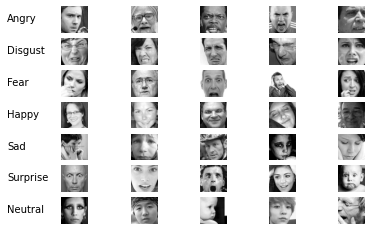

In [9]:
row = 0
for emotion in list(range(7)):

    all_emotion_images = all_data[all_data['emotion'] == emotion]
    for i in range(5):
        
        img = all_emotion_images.iloc[i,].pixels_arr.reshape(48,48)
        lab = emotions[emotion]
        
        plt.subplot(7,5,row+i+1)
        plt.imshow(img, cmap='binary_r')
        plt.axis('off')
    plt.text(-600, 27, s = str(lab), fontsize=10)
    row += 5

plt.show()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(all_data['pixels_arr'], all_data['emotion'], test_size=0.2, random_state=12345)
print("Pixels as Single array")
print("Training data shape: ", X_train.shape)
print("Test data shape", X_test.shape)

Pixels as Single array
Training data shape:  (560,)
Test data shape (140,)


In [11]:
x_unraveled = pd.DataFrame(list(map(np.ravel, all_data['pixels_arr'])))
X_train_unrav, X_test_unrav, y_train_unrav, y_test_unrav = train_test_split(x_unraveled, y, test_size=0.2, random_state=12345)
print("Pixels as columns")
print("Training data shape: ", X_train_unrav.shape)
print("Test data shape", X_test_unrav.shape)


Pixels as columns
Training data shape:  (560, 2304)
Test data shape (140, 2304)


In [12]:
X_train_im, X_test_im, y_train_im, y_test_im = train_test_split(X, y, test_size=0.2, random_state=12345)
print("Converted Images")
print("Training data shape: ", X_train_im.shape)
print("Test data shape", X_test_im.shape)

Converted Images
Training data shape:  (560, 48, 48, 1)
Test data shape (140, 48, 48, 1)


## K Nearest Neighbors Model

In [13]:
knn = KNeighborsClassifier(algorithm='auto')
param_grid = dict(n_neighbors=list(range(1, 31)))
model_KNN = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy',verbose=1)

model_KNN.fit(X_train_unrav, y_train)
y_pred_KNN = model_KNN.predict(X_test_unrav)


Fitting 10 folds for each of 30 candidates, totalling 300 fits


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


In [14]:
accuracy = {}

In [15]:
accuracy['KNN'] = accuracy_score(y_pred_KNN, y_test)

print(f"The model is {accuracy['KNN']*100:.2f}% accurate")

The model is 26.43% accurate


## SVM Model

In [16]:
# param_grid = {'C':[1,10],'gamma':[0.001,0.1],'kernel':['rbf','poly']}
param_grid = {'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly', 'linear']}
svc = svm.SVC(probability=True)
print("The training of the model is started, please wait for while as it may take few minutes to complete")

model_SVM = GridSearchCV(svc,param_grid)

start = time.time()
model_SVM.fit(X_train_unrav,y_train)
end = time.time()

print(f"Train time {end-start}")

The training of the model is started, please wait for while as it may take few minutes to complete


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Train time 470.7496259212494


In [17]:
print('The Model is trained well with the given images')
model_SVM.best_params_

The Model is trained well with the given images


{'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}

In [18]:
y_pred_SVM = model_SVM.predict(X_test_unrav)
accuracy['SVM'] = accuracy_score(y_pred_SVM, y_test)

print(f"The model is {accuracy['SVM']*100:.2f}% accurate")

The model is 25.00% accurate


## Bernoulli Naive Bayes Model

In [19]:
alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}

bnb = BernoulliNB(binarize=0.1)
model_BNB = GridSearchCV(bnb, alphas, scoring='accuracy')
model_BNB.fit(X_train_unrav, y_train) 

y_pred_BNB = model_BNB.predict(X_test_unrav) 
accuracy['BNB'] = accuracy_score(y_pred_BNB,y_test)

print(f"The model is {accuracy['BNB']*100:.2f}% accurate")
# for test_al, test_score in zip(alphas['alpha'], model_BNB.cv_results_['mean_test_score']):
#     print(f"alpha value {test_al:6} had an accuracy of {test_score*100:.1f}%")            

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


The model is 27.14% accurate


## Multinomial Naive Bayes Model

In [20]:
model_MNB = MultinomialNB()
model_MNB.fit(X_train_unrav, y_train)
y_pred_MNB = model_MNB.predict(X_test_unrav)
accuracy['MNB'] = accuracy_score(y_pred_MNB,y_test)

print(f"The Naive Bayes model is {accuracy['MNB']*100:.2f}% accurate")

The Naive Bayes model is 17.86% accurate


## Gaussian Naive Naive Bayes Model

In [21]:
model_GNB2 = GaussianNB(var_smoothing=.1)
model_GNB2.fit(X_train_unrav, y_train)
y_pred_GNB2 = model_GNB2.predict(X_test_unrav)
accuracy['GNB'] = accuracy_score(y_pred_GNB2,y_test)
print(f"Gaussian Naive Bayes model with var_smoothing set to 0.1 had accuracy {accuracy['GNB']*100:.2f}%")

Gaussian Naive Bayes model with var_smoothing set to 0.1 had accuracy 17.86%


## CNN Model 

In [48]:
scaler = StandardScaler()
scaler.fit(X_train_unrav)
X_train_unrav = scaler.transform(X_train_unrav)
X_test_unrav = scaler.transform(X_test_unrav)
param_grid = {'alpha': 10.0 ** -np.arange(1, 7),
             'solver': ['lbfgs', 'sgd', 'adam'],
             'hidden_layer_sizes': [250, 100, 50, 25, 5]}
clf = GridSearchCV(MLPClassifier(random_state=12345), param_grid)
clf.fit(X_train_unrav, y_train_unrav)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or sca

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) 

GridSearchCV(estimator=MLPClassifier(random_state=12345),
             param_grid={'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06]),
                         'hidden_layer_sizes': [250, 100, 50, 25, 5],
                         'solver': ['lbfgs', 'sgd', 'adam']})

In [51]:
# From https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
print("Best parameters set found on training set:")
print()
print(clf.best_params_)
print()
print("Grid scores on training set:")
print()
means = clf.cv_results_["mean_test_score"]
stds = clf.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

Best parameters set found on training set:

{'alpha': 1e-05, 'hidden_layer_sizes': 100, 'solver': 'lbfgs'}

Grid scores on training set:

0.298 (+/-0.055) for {'alpha': 0.1, 'hidden_layer_sizes': 250, 'solver': 'lbfgs'}
0.307 (+/-0.046) for {'alpha': 0.1, 'hidden_layer_sizes': 250, 'solver': 'sgd'}
0.304 (+/-0.059) for {'alpha': 0.1, 'hidden_layer_sizes': 250, 'solver': 'adam'}
0.305 (+/-0.065) for {'alpha': 0.1, 'hidden_layer_sizes': 100, 'solver': 'lbfgs'}
0.298 (+/-0.056) for {'alpha': 0.1, 'hidden_layer_sizes': 100, 'solver': 'sgd'}
0.300 (+/-0.056) for {'alpha': 0.1, 'hidden_layer_sizes': 100, 'solver': 'adam'}
0.298 (+/-0.033) for {'alpha': 0.1, 'hidden_layer_sizes': 50, 'solver': 'lbfgs'}
0.298 (+/-0.064) for {'alpha': 0.1, 'hidden_layer_sizes': 50, 'solver': 'sgd'}
0.293 (+/-0.048) for {'alpha': 0.1, 'hidden_layer_sizes': 50, 'solver': 'adam'}
0.307 (+/-0.091) for {'alpha': 0.1, 'hidden_layer_sizes': 25, 'solver': 'lbfgs'}
0.304 (+/-0.082) for {'alpha': 0.1, 'hidden_layer_sizes

In [52]:
print("Detailed classification report for optimal parameters:")
print()
print("The model is trained on the full training set.")
print("The scores are computed on the full test set.")
print()
y_true, y_pred = y_test_unrav, clf.predict(X_test_unrav)
print(classification_report(y_true, y_pred))
print()

Detailed classification report for optimal parameters:

The model is trained on the full training set.
The scores are computed on the full test set.

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.00      0.00      0.00         2
           2       0.11      0.19      0.14        16
           3       0.33      0.49      0.40        37
           4       0.40      0.11      0.17        19
           5       0.24      0.38      0.29        16
           6       0.40      0.42      0.41        24

    accuracy                           0.28       140
   macro avg       0.21      0.22      0.20       140
weighted avg       0.25      0.28      0.25       140




/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa